# SETUP

In [1]:
import os
import json
from matplotlib import pyplot as plt
import math
import numpy as np
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import pandas as pd
import seaborn as sns
from PIL import Image

In [2]:
# set plot params
plt.rcParams.update({'font.size': 22})
plt.show()
plot_dir = 'Plots/'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

# uci primary colors
uci_blue = (0/255, 62/255, 120/255)
uci_gold = (253/255, 185/255, 19/255)

# uci secondary color palette
uci_light_blue = (106/255, 162/255, 184/255)
uci_light_gray = (197/255, 190/255, 181/255)
uci_dark_blue = (27/255, 61/255, 109/255)
uci_orange = (247/255, 141/255, 45/255)
uci_light_yellow = (247/255, 235/255, 95/255)
uci_dark_gray = (85/255, 87/255, 89/255)
uci_lime_green = (122/255, 184/255, 0/255)

# color blind friendly colors
# https://gist.github.com/thriveth/8560036
color_blinds = {
    'blue':   [55/255,  126/255, 184/255],  #377eb8 
    'orange': [255/255, 127/255, 0/255],    #ff7f00
    'green':  [77/255,  175/255, 74/255],   #4daf4a
    'pink':   [247/255, 129/255, 191/255],  #f781bf
    'brown':  [166/255, 86/255,  40/255],   #a65628
    'purple': [152/255, 78/255,  163/255],  #984ea3
    'gray':   [153/255, 153/255, 153/255],  #999999
    'red':    [228/255, 26/255,  28/255],   #e41a1c
    'yellow': [222/255, 222/255, 0/255]     #dede00
} 
color_blinds_list = [color_blinds[color] for color in color_blinds]

object_color = uci_blue

# BINVOX

In [3]:
import binvox as bv
binvox_path = 'map_voxels.binvox'
voxels = bv.Binvox.read(binvox_path, 'dense')
voxels_data = voxels.data
voxels_scale = voxels.scale 
voxels_trans = voxels.translate
voxels_res = (np.absolute(voxels_trans)) * 2 * voxels_scale

In [4]:
_global_plt_patches = None

def plot_map(axis, object_color=uci_blue):
    global _global_plt_patches
    if _global_plt_patches is None:
        origin = voxels_data[int(voxels_data.shape[1]/2), int(voxels_data.shape[0]/2), :]
        floor_dim = max([i for i, x in enumerate(origin) if x])
        scale = voxels_scale * 100
        shift = 100
        _global_plt_patches = []
        for x in range(voxels_data.shape[0]):
            for y in range(voxels_data.shape[1]):
                for z in range(voxels_data.shape[2]):
                    if voxels_data[x, y, z] and z > floor_dim:
                        #x_loc = x - shift - scale/2 # align to left for plt.rect
                        #y_loc = y - shift - scale/2 # align to bottom for plt.rect
                        #patch = patches.Rectangle((x_loc, y_loc), scale, scale, color = object_color)
                        patch = patches.Rectangle((x-shift, y-shift), 1, 1, color = object_color)
                        _global_plt_patches.append(patch)
                        break
    # add list of patches (much quicker than iteratively drawing)
    map_stuff = PatchCollection(_global_plt_patches, match_original=True)
   # axis.gca().add_collection(map_stuff)
    axis.add_collection(map_stuff)

In [5]:
def plot_spawns_goals(
    drone_radius = 0.5,
    goal_tolerance = 4,
    goal_distance = 100,
    spawns = [],
    goals = [],
    spawn_color = color_blinds['red'],
    goal_color = color_blinds['orange'],
    goal_wedge = True,
):
    # patch stuff
    spawn_patches = []
    goal_patches = []
    for idx in range(len(spawns)):
        spawn = spawns[idx]
        goal = goals[idx]
        spawn_patch = patches.Rectangle(
            (spawn[0], spawn[1]), 
            drone_radius, 
            drone_radius, 
            color=spawn_color,
        )
        spawn_patches.append(spawn_patch)
        if goal_wedge:
            radius = math.sqrt(goal[0]**2 + goal[1]**2)
            goal_patch = patches.Wedge(
                (spawn[0], spawn[1]), 
                goal_distance+goal_tolerance, 
                goal[0], goal[1], 
                width=2*goal_tolerance,
                color=goal_color,
            )
        else:
            goal_patch = patches.Circle(
                (goal[0], goal[1]), 
                goal_tolerance, 
                color=goal_color,
            )
        goal_patches.append(goal_patch)
    # add list of patches (much quicker than iteratively drawing)
    spawn_collection = PatchCollection(spawn_patches, match_original=True)
    goal_collection = PatchCollection(goal_patches, match_original=True)
    plt.gca().add_collection(goal_collection)
    plt.gca().add_collection(spawn_collection)

In [6]:
def plot_environment(name='Learning Environment (to scale)'):
    fig = plt.figure()
    fig.set_size_inches((6, 6))
    plt.title(name)
    plt.xlabel('y [meters]')
    plt.ylabel('x [meters]')
    plt.xlim(-120, 120)
    plt.ylim(-120, 120)
    # custom legend hack
    plt.scatter(-999, -999, marker='s', color=object_color)
    plt.scatter(-999, -999, marker='s', color=train_spawn_color)
    plt.scatter(-999, -999, color=train_goal_color)
    #plt.scatter(-999, -999, color=eval_spawn_color)
    #plt.scatter(-999, -999, color=eval_goal_color)
    plt.legend([
        'Objects', 
        'Spawn', 
        'Goal', 
        #'Eval Spawn', 
        #'Eval Goal'
    ],
               loc='center left', 
               bbox_to_anchor=(1, 0.5),)

# EVALUATIONS

In [7]:
# json files output with all string key names
# process so that the evaluation dictionary structure is such:
    # episode # - int
        # step # - int
            # state - dictionary of misc key, value pairs for that state
def process_episodes(json_evaluation):
    nEpisodes = len(json_evaluation)
    episodes = [None] * nEpisodes
    episode_idx = 0
    for episode_str in json_evaluation:
        if 'episode_' not in episode_str:
            continue
        json_episode = json_evaluation[episode_str]
        nSteps = len(json_episode)
        states = [None] * nSteps
        for step_str in json_episode:
            step_num = int(step_str.split('_')[1])
            state = json_episode[step_str]
            states[step_num] = state
        episodes[episode_idx] = states
        episode_idx += 1
    return episodes
def read_evaluations(evaluation_folder, nEpisodes):
    evaluation_files = [file for file in os.listdir(evaluation_folder) if 'states' in file]
    nEvaluations = len(evaluation_files)
    evaluations = [None] * nEvaluations
    for evaluation_file in evaluation_files:
        if '.json' not in evaluation_file:
            continue
        parts = evaluation_file.split('.')[0].split('_')
        left_episode = int(parts[-2])
        right_episode = int(parts[-1])
        evaluation_number = int(left_episode / nEpisodes)
        print(evaluation_file, evaluation_number)
        json_evaluation = json.load(open(evaluation_folder + evaluation_file, 'r'))
        episodes = process_episodes(json_evaluation)
        evaluations[evaluation_number] = episodes
    return evaluations
# architecture for evaluations:
# evaluations - list of episodes (indexed of evaluation number) - 0 idx is first evaluation before training
    # episodes - list of states (indexed by step number)
        # states - dict of (key, value) pairs for state at all_evaluations[instance][evaluation][episode][step]

In [8]:
# read evaluations from each instance
# each a sub folder from parent with which this eval notebook is in
# for each key is expected number of episodes per set
instances = {
    'EvaluateEnvironment' : 6, 
    'TrainEnvironment' : 100, 
}
all_evaluations = {}
for instance in instances:
    all_evaluations[instance] = read_evaluations(instance + '/', instances[instance])

states__episodes_37_42.json 6
states__episodes_157_162.json 26
states__episodes_427_432.json 71
states__episodes_283_288.json 47
states__episodes_241_246.json 40
states__episodes_367_372.json 61
states__episodes_811_816.json 135
states__episodes_85_90.json 14
states__episodes_19_24.json 3
states__episodes_223_228.json 37
states__episodes_109_114.json 18
states__episodes_43_48.json 7
states__episodes_715_720.json 119
states__episodes_655_660.json 109
states__episodes_175_180.json 29
states__episodes_631_636.json 105
states__episodes_187_192.json 31
states__episodes_13_18.json 2
states__episodes_643_648.json 107
states__episodes_253_258.json 42
states__episodes_403_408.json 67
states__episodes_565_570.json 94
states__episodes_181_186.json 30
states__episodes_757_762.json 126
states__episodes_259_264.json 43
states__episodes_337_342.json 56
states__episodes_121_126.json 20
states__episodes_433_438.json 72
states__episodes_91_96.json 15
states__episodes_541_546.json 90
states__episodes_661

states__episodes_4001_4100.json 40
states__episodes_9701_9800.json 97
states__episodes_11401_11500.json 114
states__episodes_11601_11700.json 116
states__episodes_9201_9300.json 92
states__episodes_5101_5200.json 51


In [9]:
for instance in instances:
    for set_num, episodes in enumerate(all_evaluations[instance]):
        for episode, states in enumerate(episodes):
            for step, state in enumerate(states):
                if step > 0:
                    action = state['transcribed_action']
                    s = action.replace('[', '').replace(']', '').split(' ')
                    actions = []
                    for a in s:
                        if a != '':
                            actions.append(float(a))
                    if actions[0] < -1 or actions[0] > 1:
                        print('err')
                    if actions[1] < -1 or actions[1] > 1:
                        print('err')

In [10]:
# read in info from config file
config_file = json.load(open('configuration.json', 'r'))
gamma = config_file['components']['Model']['gamma']
best_score = config_file['components']['Evaluator']['best_score']
best_eval = config_file['components']['Evaluator']['best_counter'] / 100
n_train_episodes = config_file['components']['TrainEnvironment']['episode_counter']
n_train_steps = config_file['components']['TrainEnvironment']['step_counter']
print(f'Reached max distance of {best_score} at evaluation # {best_eval}')
print(f'after training for = {n_train_episodes} episodes and {n_train_steps} steps')

Reached max distance of 64 at evaluation # 100.0
after training for = 12100 episodes and 334599 steps


In [11]:
# process evaluations
_moves = {}
final_variables = {instance:{} for instance in instances}
for instance in instances:
    for set_num, episodes in enumerate(all_evaluations[instance]):
        for episode, states in enumerate(episodes):
            for step, state in enumerate(states):
                if step == 0:
                    if 'goal_distance' not in final_variables[instance]:
                        final_variables[instance]['goal_distance'] = {}
                    if episode not in final_variables[instance]['goal_distance']:
                        final_variables[instance]['goal_distance'][episode] = []
                    drone_position = np.array(state['drone_position'])
                    goal_position = np.array(state['goal_position'])
                    goal_distance = np.linalg.norm(goal_position - drone_position)
                    final_variables[instance]['goal_distance'][episode].append(goal_distance)
                    continue
                move = state['transcribed_action']
                if move not in _moves:
                    _moves[move] = 0
                _moves[move] += 1
            final_state = states[-1]
            for variable in final_state:
                if variable not in final_variables[instance]:
                    final_variables[instance][variable] = {}
                if episode not in final_variables[instance][variable]:
                    final_variables[instance][variable][episode] = []
                final_variables[instance][variable][episode].append(final_state[variable])

# print number of times each action was taken
# this is used to see if RL biased any moves
print(_moves)
# architecture of final_variables:
# instance - str name
    # variable - str name
        # episode - int number
            # final values - list of final values with increased # of training evaluations 

{'[0.0278 0.2814]': 1, '[0.8975 0.3485]': 1, '[0.9035 0.4053]': 1, '[0.7065 0.243 ]': 1, '[0.9439 0.5148]': 1, '[0.901  0.3651]': 1, '[0.9386 0.4577]': 1, '[0.5862 0.3706]': 1, '[0.9072 0.5127]': 1, '[0.492  0.2783]': 1, '[-0.2319  0.321 ]': 1, '[0.31   0.2117]': 1, '[-0.0864  0.2847]': 1, '[0.7011 0.4188]': 1, '[0.9883 0.6931]': 1, '[0.1953 0.6318]': 1, '[0.9668 0.7257]': 1, '[0.9018 0.7066]': 1, '[-0.3732  0.6143]': 1, '[0.7632 0.7422]': 1, '[0.9278 0.7104]': 1, '[-0.1737  0.6576]': 1, '[-0.966   0.9988]': 1, '[0.9716 0.9974]': 1, '[-0.4437  0.996 ]': 1, '[0.72  0.999]': 1, '[0.9992 1.    ]': 912, '[-0.2812  0.9998]': 1, '[0.9987 0.9997]': 1, '[0.9953 0.9977]': 1, '[-0.0755  0.9707]': 1, '[0.2445 0.995 ]': 1, '[0.9953 0.9899]': 1, '[-0.7473  0.9987]': 1, '[-0.6656  0.9997]': 1, '[-0.5671  0.9601]': 1, '[-0.8572  0.9994]': 1, '[0.4368 0.8986]': 1, '[0.9689 0.9583]': 1, '[0.2017 0.9135]': 1, '[0.965  0.9554]': 1, '[0.9616 0.9661]': 1, '[0.4156 0.962 ]': 1, '[0.5677 0.9985]': 1, '[0.978

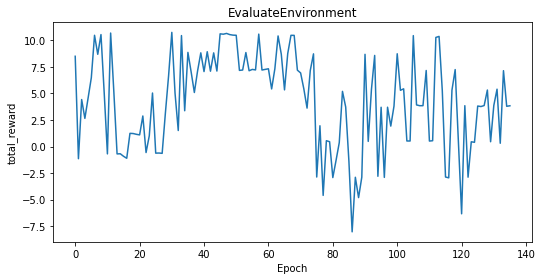

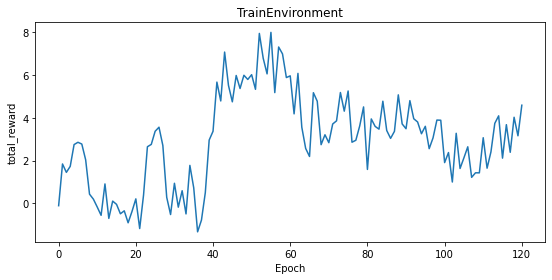

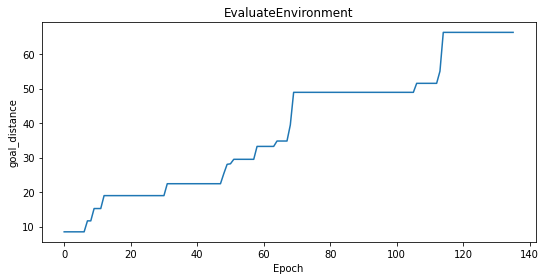

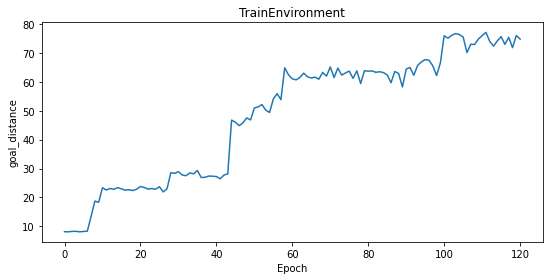

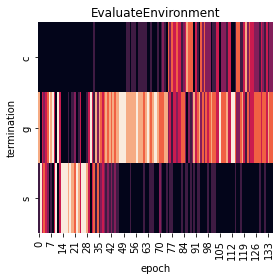

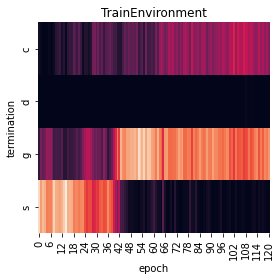

In [12]:
# PLOT RESULTS VERSUS TRAINING TIME
results_instances = [
    'EvaluateEnvironment', 
    'TrainEnvironment', 
]
# select which state variables to fetch
numerical_variables = [
    #'nSteps', 
    'total_reward', 
    'goal_distance',
]
string_variables = [
    #'transcribed_action', 
    'termination_reason',
]
all_variables = numerical_variables + string_variables

shorten = {
    'termination_reason':'termination',
}

# take mean values
for variable in all_variables:
    for instance in results_instances:
        if variable not in shorten:
            shorten[variable] = variable
        plot_name = instance + '_' + variable
        
        values = {}
        for episode in final_variables[instance][variable]:
            for evaluation in range(len(final_variables[instance][variable][episode])):
                if evaluation not in values:
                    values[evaluation] = []
                values[evaluation].append(final_variables[instance][variable][episode][evaluation])

        if variable in numerical_variables:
            aggregates = []
            nEpisodes = len(final_variables[instance][variable])
            for evaluation in values:
                aggregates.append(sum(values[evaluation])/len(values[evaluation]))
            plt.title(instance)
            plt.xlabel('Epoch')
            plt.ylabel(variable)
            plt.plot(aggregates)
            plt.tight_layout()
            fig = plt.gcf()
            fig.set_size_inches(8, 4)
            plt.savefig(plot_dir + plot_name + '.png')
            plt.show()

        if variable in string_variables:
            fig = plt.gcf()
            fig.set_size_inches(4, 4)
            aggregates = {}
            for evaluation in values:
                for name in values[evaluation]:
                    if name not in aggregates:
                        aggregates[name] = {}
                    if evaluation not in aggregates[name]:
                        aggregates[name][evaluation] = 0
                    aggregates[name][evaluation] += 1   
            df_data = {'count':[], shorten[variable]:[], 'epoch':[]}
            for name in aggregates:
                for evaluation in values:
                    if evaluation not in aggregates[name]:
                        aggregates[name][evaluation] = 0
                    count = aggregates[name][evaluation]
                    df_data['count'].append(count)
                    df_data[shorten[variable]].append(name[0])
                    df_data['epoch'].append(evaluation)
            df = pd.DataFrame(df_data)
            heatmap_data = pd.pivot_table(df, values='count', index=[shorten[variable]], columns='epoch')
            sns.heatmap(heatmap_data, cbar=False)
            plt.title(instance)
            plt.tight_layout()
            plt.savefig(plot_dir + plot_name + '.png')
            plt.show()

6


/tmp/ipykernel_14413/2519358550.py:66: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
/tmp/ipykernel_14413/2519358550.py:67: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
/tmp/ipykernel_14413/2519358550.py:68: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)


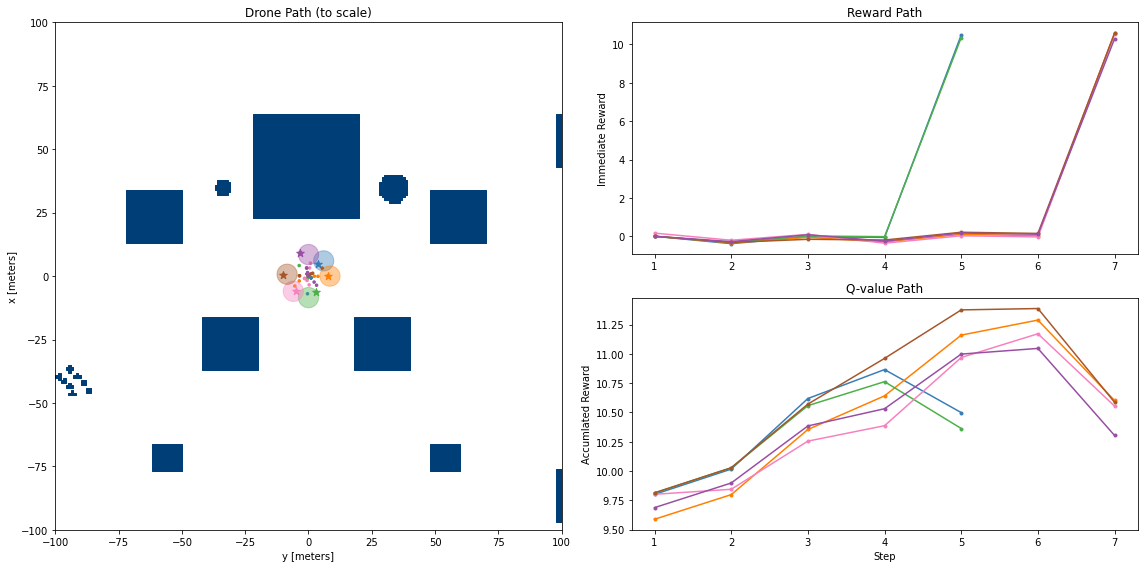

8


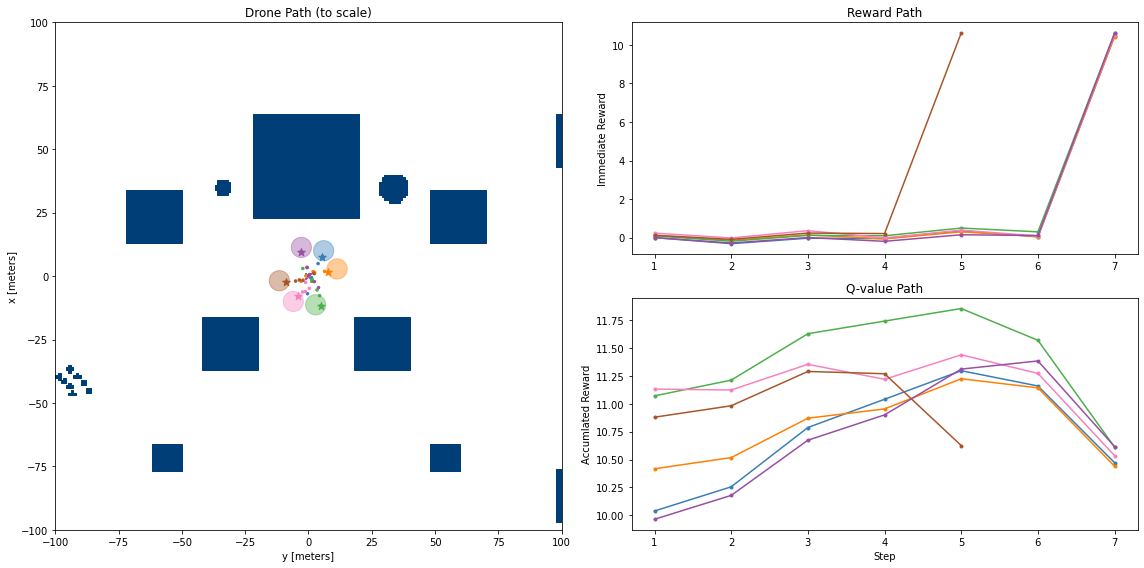

11


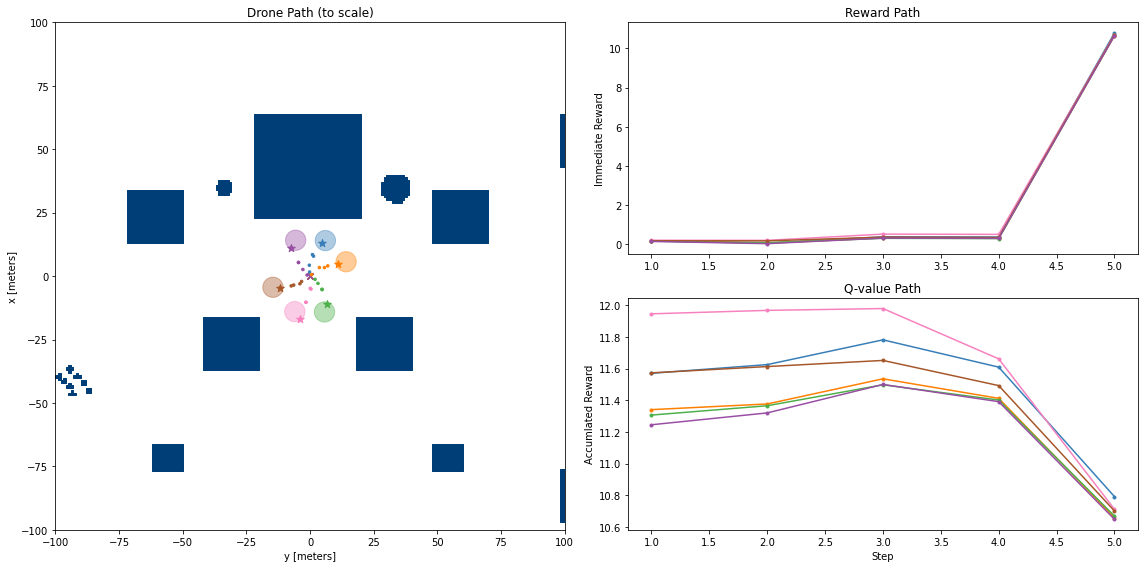

30


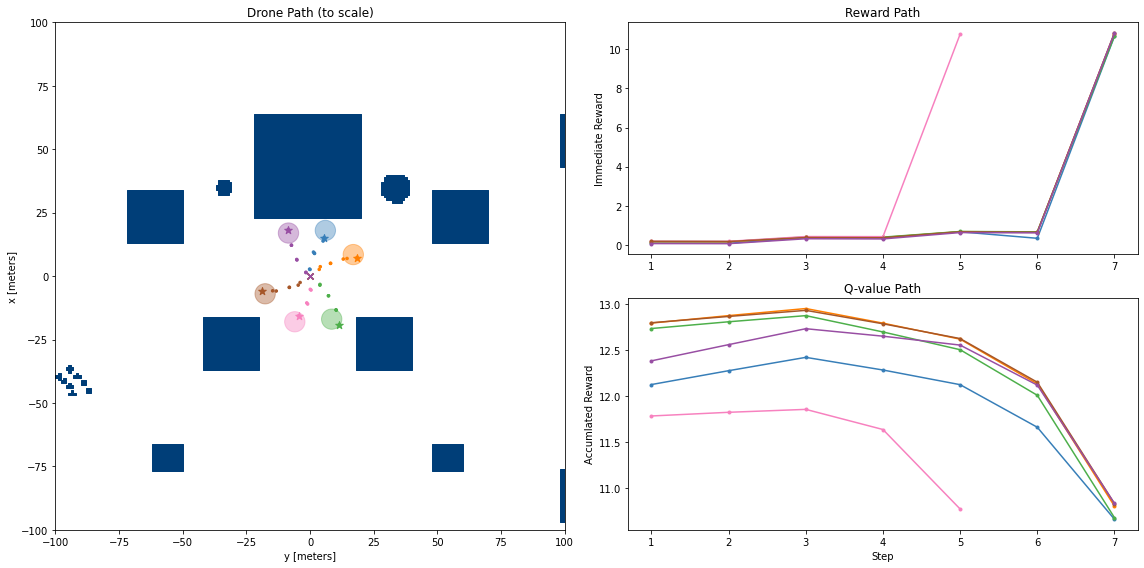

47


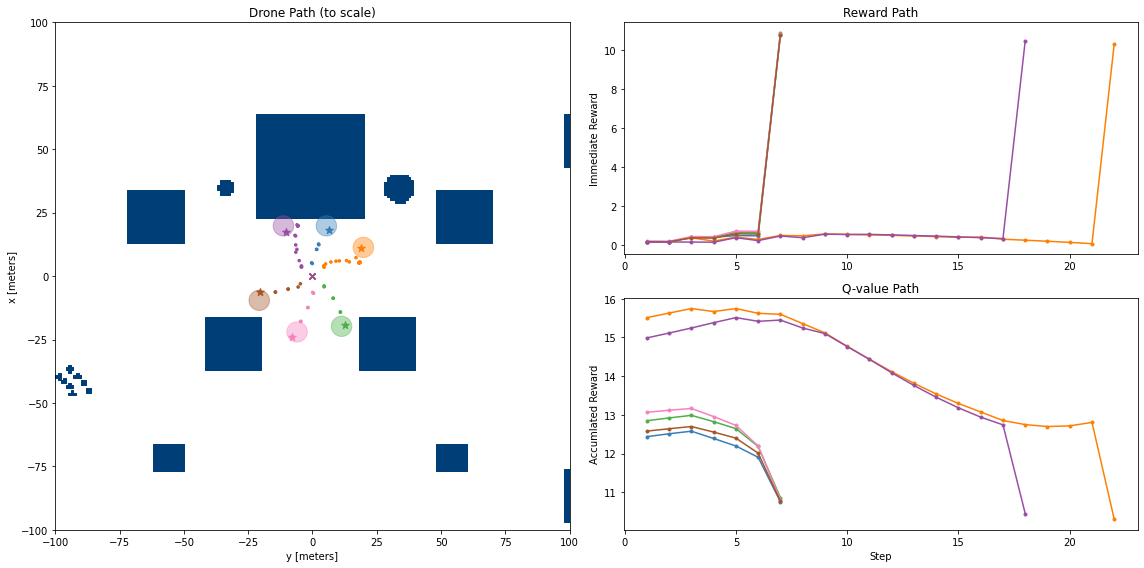

48


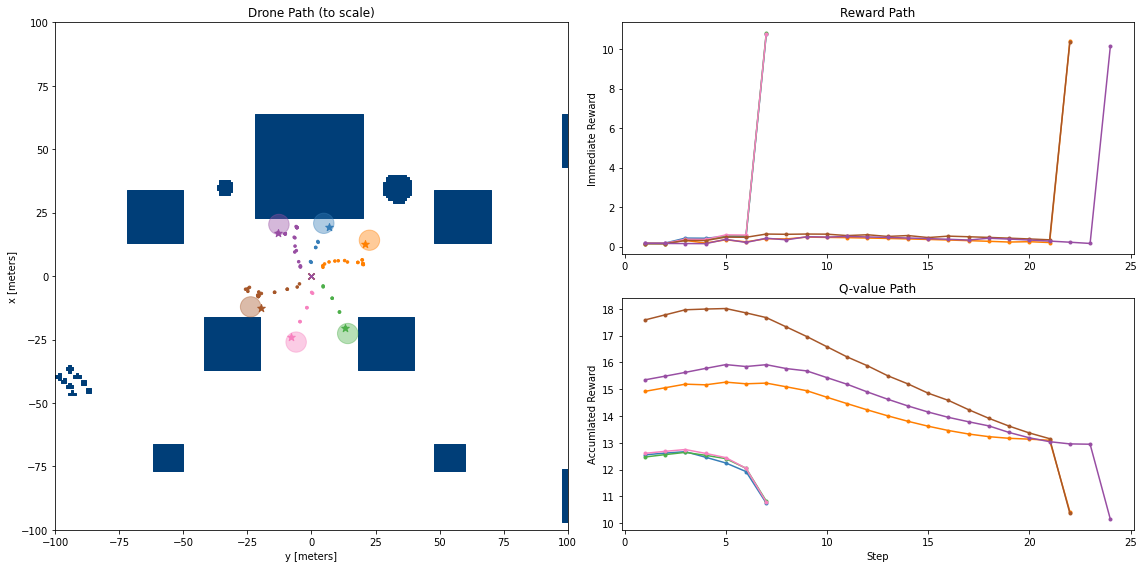

49


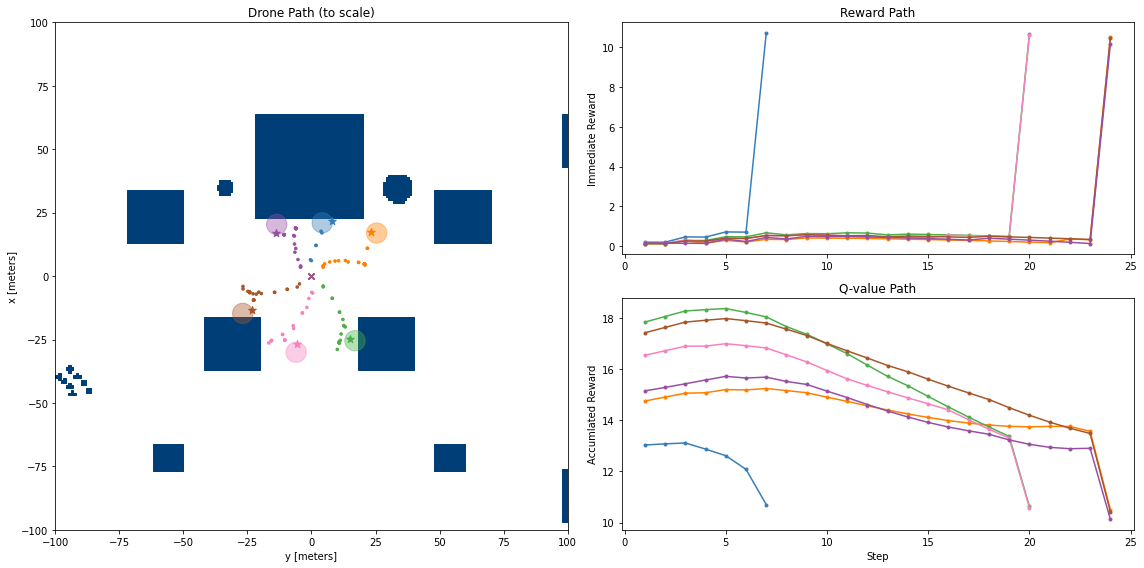

50


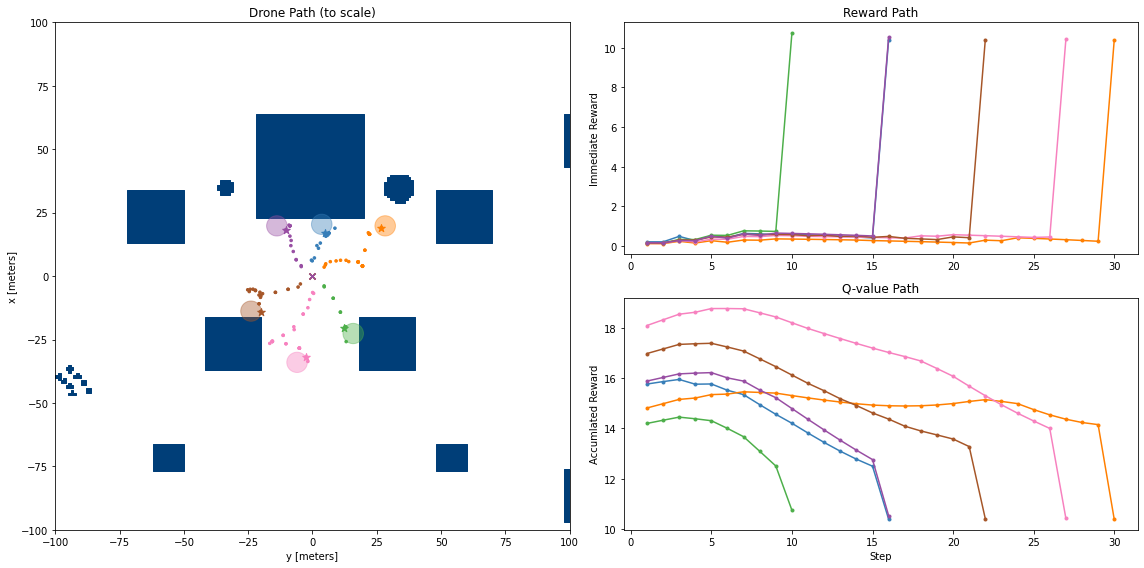

57


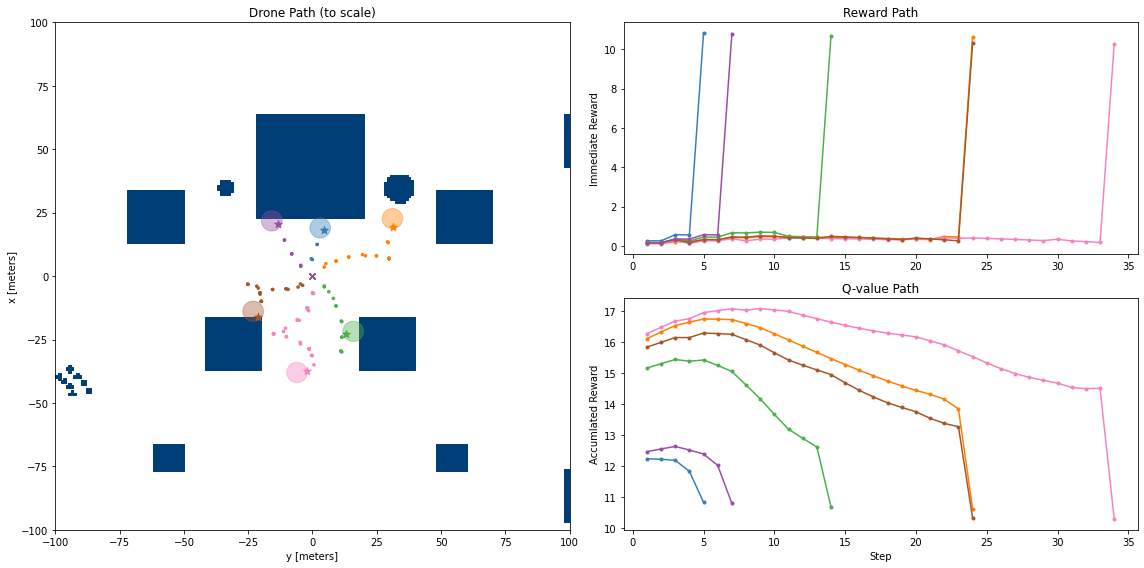

63


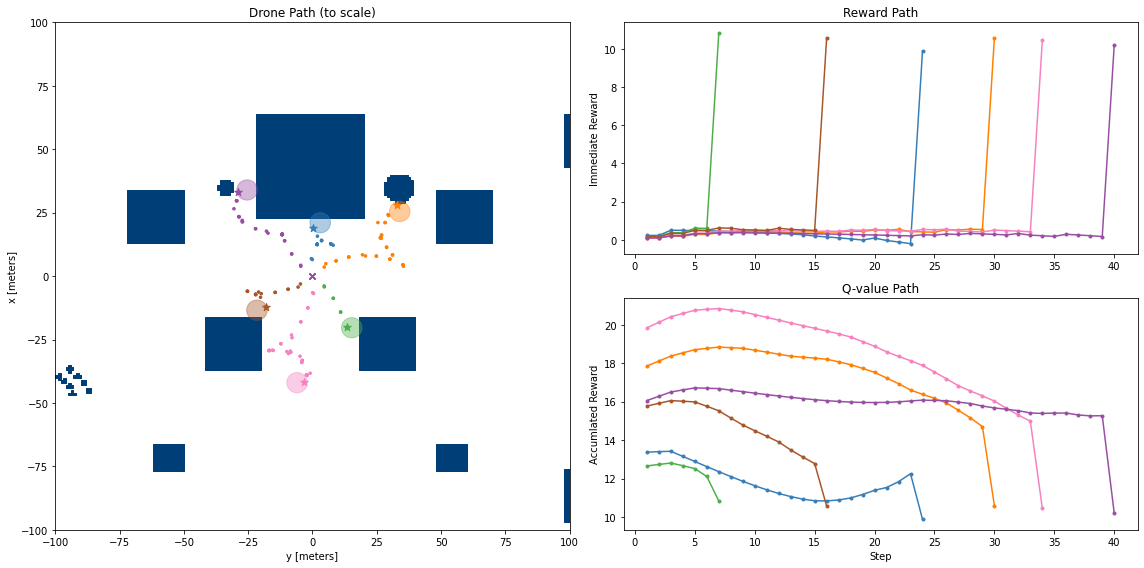

67


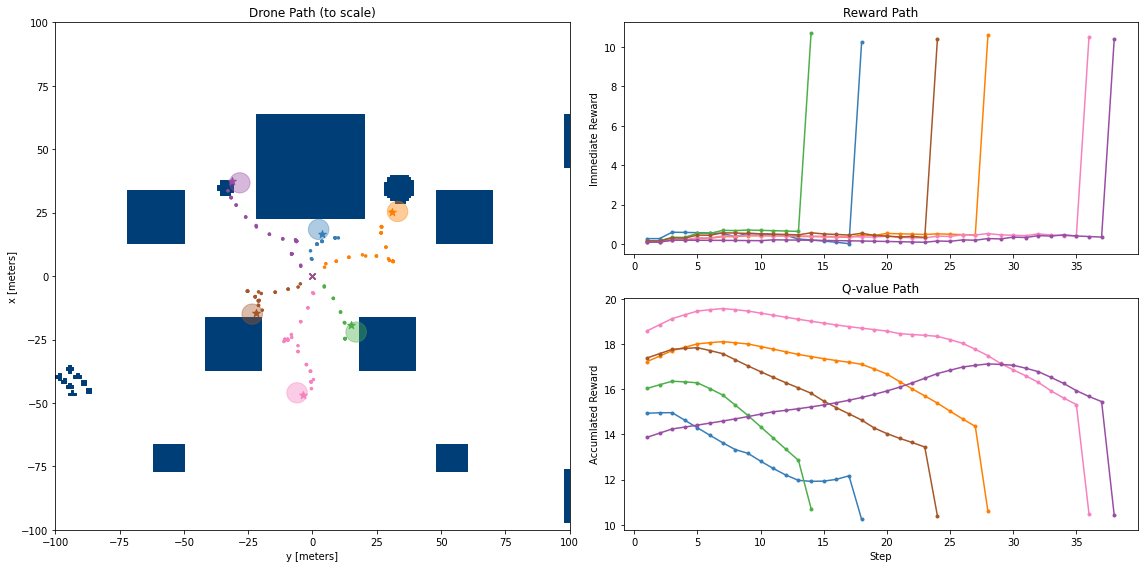

68


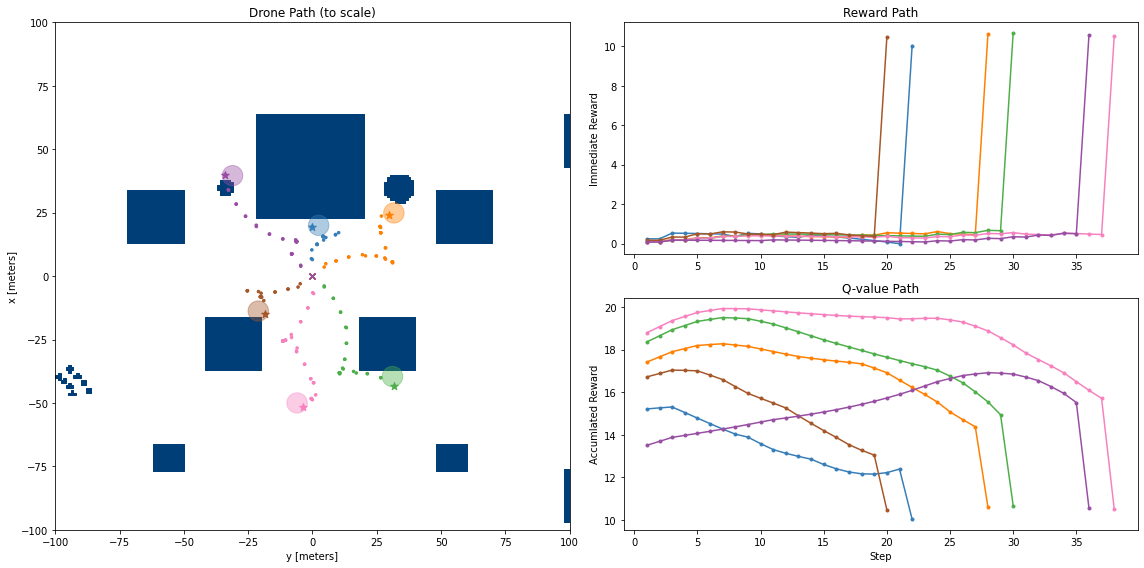

105


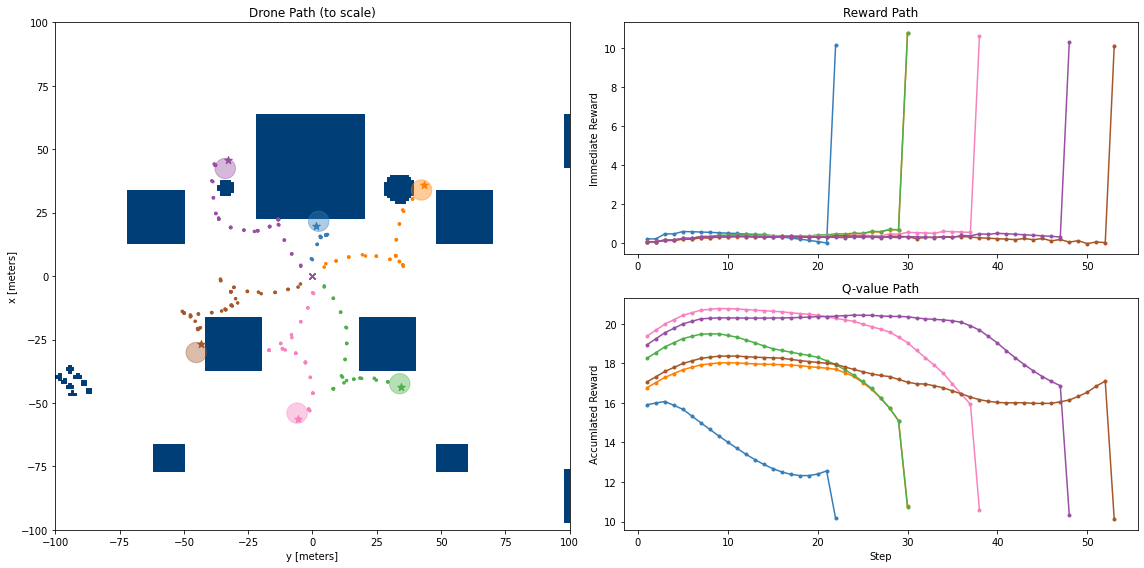

112


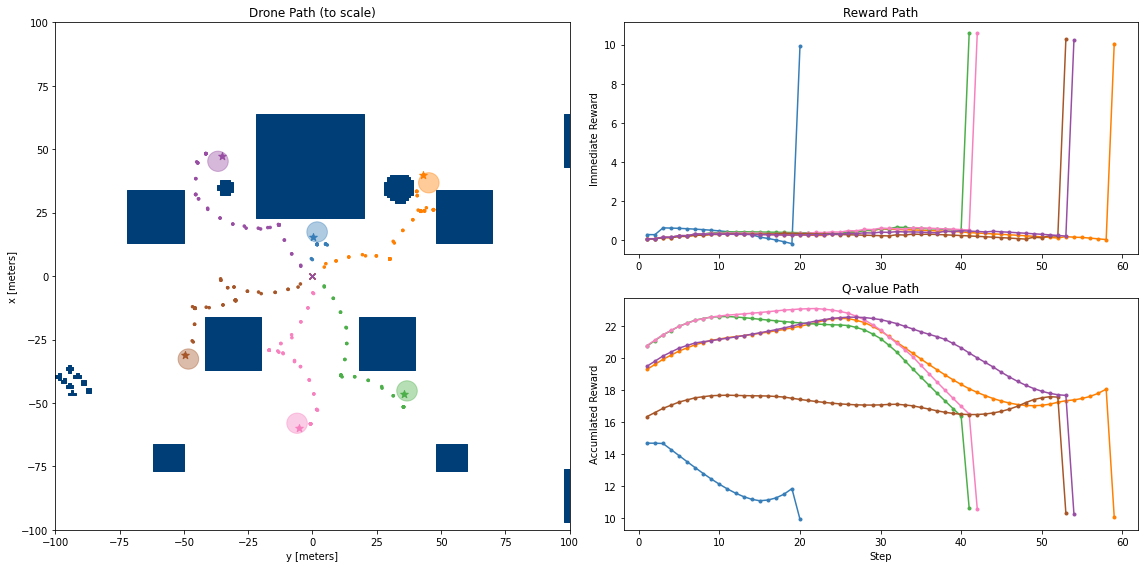

113


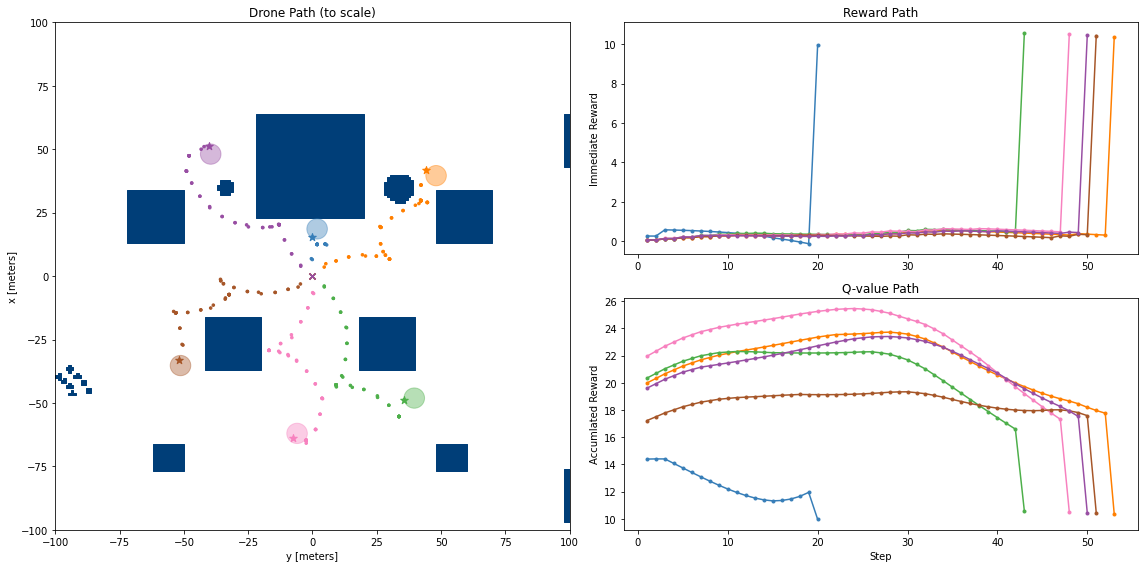

In [16]:
# PLOT SUCCESS PATHS
path_instances = [
    'EvaluateEnvironment', 
    #'TrainEnvironment', 
]
for instance in path_instances:
    evaluations = all_evaluations[instance]
    for set_num, episodes in enumerate(evaluations):
        paths = []
        reward_paths = []
        Q_paths = []
        goals = []
        spawns = []
        termination_reasons = []
        episode_numbers = []
        # do we plot this set? (change as needed)
        # you can just plot everything but its alot to chew
        view_set = True
        for episode, states in enumerate(episodes):
            # get final vaules
            final_state = episodes[episode][-1]
            termination_result = final_state['termination_result']
            if 'success' not in termination_result:
                view_set = False
                break
        if not view_set:
            continue
        for episode, states in enumerate(episodes):
            # get final vaules
            final_state = episodes[episode][-1]
            termination_reason = final_state['termination_reason']
            # build paths
            path = []
            reward_path = []
            Q_path = []
            episode_numbers.append(episode)
            # get initial value
            init_state = states[0]
            spawn = init_state['drone_position']
            goal = init_state['goal_position']
            # get intermediate values
            for step, state in enumerate(states):
                if step == 0: continue
                state = episodes[episode][step]
                drone_position = state['drone_position']
                path.append(drone_position)
                reward = state['total_reward']
                reward_path.append(reward)
                # get future values from this state
                for step2, state2 in enumerate(states[step+1:]):
                    if step == 0: continue
                    reward += (gamma**(step2-step)) * state2['total_reward']
                Q_path.append(reward)
            reward_paths.append(reward_path)
            termination_reasons.append(termination_reason)
            spawns.append(spawn)
            goals.append(goal)
            paths.append(path)
            Q_paths.append(Q_path)
            # plot every 8 episodes 
            if episode == len(episodes)-1 or (episode > 0 and episode%8 == 0):
                print(set_num)
                # subplots
                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
                fig.set_size_inches(16, 8)
                ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
                ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
                ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
                # PLOT DRONE PATH
                ax1.set_title('Drone Path (to scale)')
                ax1.set_xlabel('y [meters]')
                ax1.set_ylabel('x [meters]')
                ax1.set_xlim(-100, 100)
                ax1.set_ylim(-100, 100)
                # show objects on map from binvox
                plot_map(ax1)
                # legend hack
                ax1.scatter(-999, -999, marker='s', color=object_color) # off map just for legend
                legend = [
                #    'Objects'
                ]
                for idx in range(len(termination_reasons)):
                    color = color_blinds_list[idx]
                    ax1.scatter(spawns[idx][1], spawns[idx][0], marker='x', color=color) # spawn location
                    termination_reason = termination_reasons[idx]
                    legend.append('E' + str(episode_numbers[idx]) + ':' + termination_reason)
                plt_patches = []
                for idx in range(len(paths)):
                    color = color_blinds_list[idx]
                    # plot goal
                    obj = plt.Circle((goals[idx][1], goals[idx][0]), 4, color=color, alpha=0.4)
                    plt_patches.append(obj)
                    # plot points
                    for point in paths[idx]:
                        # using generic quad copter size for point sizes (set this to your drone value)
                        radius = 0.5
                        point = plt.Circle((point[1], point[0]), radius, color=color)
                        plt_patches.append(point)
                    # plot end point
                    ax1.scatter(paths[idx][-1][1], paths[idx][-1][0], marker='*', s=64, color=color) # end location
                map_stuff = PatchCollection(plt_patches, match_original=True)
                ax1.add_collection(map_stuff)
                # PLOT REWARDS
                ax2.set_title('Reward Path')
                #ax2.set_xlabel('Step')
                ax2.set_ylabel('Immediate Reward')
                for idx in range(len(reward_paths)):
                    color = color_blinds_list[idx]
                    ax2.plot([i+1 for i in range(len(reward_paths[idx]))], reward_paths[idx], color=color, marker='.')
                # PLOT Q-VALUES
                ax3.set_title('Q-value Path')
                ax3.set_xlabel('Step')
                ax3.set_ylabel('Accumlated Reward')
                for idx in range(len(Q_paths)):
                    color = color_blinds_list[idx]
                    ax3.plot([i+1 for i in range(len(Q_paths[idx]))], Q_paths[idx], color=color, marker='.')
                # plot legend
                #ax2.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
                plt.tight_layout()
                # Show the graph
                plot_name = instance + '_best_path'
                plt.savefig(plot_dir + plot_name + '.png')
                plt.show()
                # reset path arrays
                paths = []
                reward_paths = []
                Q_paths = []
                goals = []
                spawns = []
                termination_reasons = []
                episode_numbers = []

# SUMMARY FIGURE

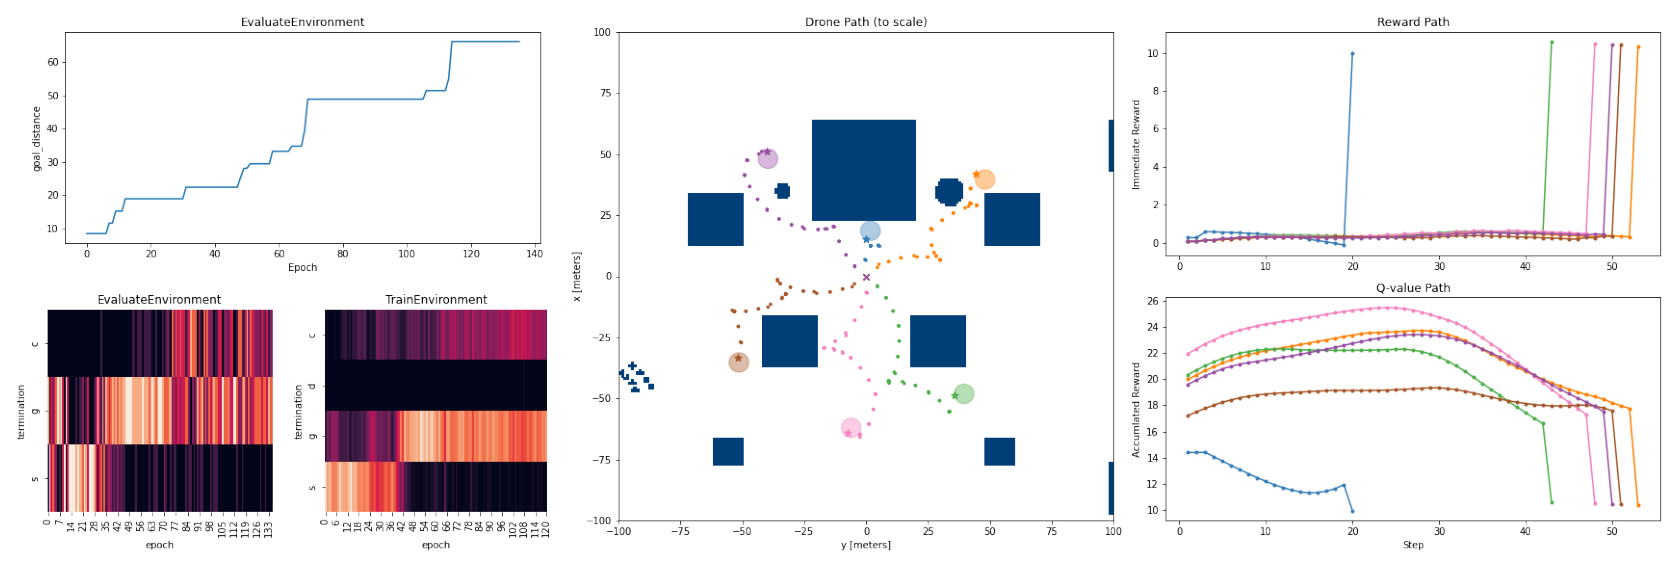

In [14]:
img1 = np.asarray(Image.open(plot_dir + 'EvaluateEnvironment_goal_distance.png'))
img2 = np.asarray(Image.open(plot_dir + 'EvaluateEnvironment_best_path.png'))
img3 = np.asarray(Image.open(plot_dir + 'EvaluateEnvironment_termination_reason.png'))
img4 = np.asarray(Image.open(plot_dir + 'TrainEnvironment_termination_reason.png'))

gshape = [img2.shape[0], img1.shape[1] + img2.shape[1], 4]
gimg = np.zeros(gshape, dtype=np.uint8)
gimg[:img1.shape[0],:img1.shape[1],:] = img1
gimg[:,img1.shape[1]:,:] = img2
gimg[img1.shape[0]:,:img3.shape[1],:] = img3
gimg[img1.shape[0]:,img3.shape[1]:img1.shape[1],:] = img4

plt.imshow(gimg)
plt.axis('off')
fig = plt.gcf()
fig.set_size_inches(24, 8)
plt.tight_layout()
plt.show()

# SUPPLEMENTAL SCRIPTS

In [ ]:
# VIEW ALL PATHS (THIS CAN BE ALOT)
# # plot final paths (run necessary binvox stuff at bottom of notebook to use plot_map)
for instance in instances:
    evaluations = all_evaluations[instance]
    if 'train' in instance:
        evaluations = [evaluations[-1]]
    for set_num, episodes in enumerate(evaluations):
        if set_num > 100:
            continue
        paths = []
        reward_paths = []
        Q_paths = []
        goals = []
        spawns = []
        termination_reasons = []
        episode_numbers = []
        for episode, states in enumerate(episodes):
            path = []
            reward_path = []
            Q_path = []
            episode_numbers.append(episode)
            # get initial value
            init_state = states[0]
            spawn = init_state['drone_position']
            spawns.append(spawn)
            goal = init_state['goal_position']
            goals.append(goal)
            # get intermediate values
            for step, state in enumerate(states):
                if step == 0: continue
                state = episodes[episode][step]
                drone_position = state['drone_position']
                path.append(drone_position)
                reward = state['total_reward']
                reward_path.append(reward)
                # get future values from this state
                for step2, state2 in enumerate(states[step+1:]):
                    if step == 0: continue
                    reward += (gamma**(step2-step)) * state2['total_reward']
                Q_path.append(reward)
            paths.append(path)
            reward_paths.append(reward_path)
            Q_paths.append(Q_path)
            # get final vaules
            final_state = episodes[episode][-1]
            termination_reason = final_state['termination_reason']
            termination_reasons.append(termination_reason)
            # plot every 8 episodes 
            if episode == len(episodes)-1 or (episode > 0 and episode%8 == 0):
                # subplots
                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
                if 'train' in instance:
                    fig.suptitle(instance + ' Final Set')
                else:
                    fig.suptitle(instance + ' Set #' + str(set_num))
                fig.set_figheight(8)
                fig.set_figwidth(16)
                ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
                ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
                ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
                # PLOT DRONE PATH
                ax1.set_title('Drone Path (to scale)')
                ax1.set_xlabel('y [meters]')
                ax1.set_ylabel('x [meters]')
                ax1.set_xlim(-100, 100)
                ax1.set_ylim(-100, 100)
                # show objects on map from binvox
                plot_map(ax1)
                # legend hack
                ax1.scatter(-999, -999, marker='s', color=object_color) # off map just for legend
                legend = [
                #    'Objects'
                ]
                for idx in range(len(termination_reasons)):
                    color = color_blinds_list[idx]
                    ax1.scatter(spawns[idx][1], spawns[idx][0], marker='x', color=color) # spawn location
                    termination_reason = termination_reasons[idx]
                    legend.append('E' + str(episode_numbers[idx]) + ':' + termination_reason)
                plt_patches = []
                for idx in range(len(paths)):
                    color = color_blinds_list[idx]
                    # plot goal
                    obj = plt.Circle((goals[idx][1], goals[idx][0]), 4, color=color, alpha=0.4)
                    plt_patches.append(obj)
                    # plot points
                    for point in paths[idx]:
                        # using generic quad copter size for point sizes (set this to your drone value)
                        radius = 0.5
                        point = plt.Circle((point[1], point[0]), radius, color=color)
                        plt_patches.append(point)
                    # plot end point
                    ax1.scatter(paths[idx][-1][1], paths[idx][-1][0], marker='*', s=64, color=color) # end location
                map_stuff = PatchCollection(plt_patches, match_original=True)
                ax1.add_collection(map_stuff)
                # PLOT REWARDS
                ax2.set_title('Reward Path')
                #ax2.set_xlabel('Step')
                ax2.set_ylabel('Immediate Reward')
                for idx in range(len(reward_paths)):
                    color = color_blinds_list[idx]
                    ax2.plot([i+1 for i in range(len(reward_paths[idx]))], reward_paths[idx], color=color, marker='.')
                # PLOT Q-VALUES
                ax3.set_title('Q-value Path')
                ax3.set_xlabel('Step')
                ax3.set_ylabel('Accumlated Reward')
                for idx in range(len(Q_paths)):
                    color = color_blinds_list[idx]
                    ax3.plot([i+1 for i in range(len(Q_paths[idx]))], Q_paths[idx], color=color, marker='.')
                # plot legend
                ax2.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
                # Show the graph
                plt.show()
                # reset path arrays
                paths = []
                reward_paths = []
                Q_paths = []
                goals = []
                spawns = []
                termination_reasons = []
                episode_numbers = []

In [17]:
# MOVE HISTORY
# view moves for each evaluation for each episode
# also keeps track of an AirSim bug that places drone below floor
bugs = []
read_instances =[
    'EvaluateEnvironment', 
    #'TrainEnvironment', 
]
for instance in read_instances:
    evaluations = all_evaluations[instance]
    for set_num, episodes in enumerate(evaluations):
        for episode, states in enumerate(episodes):
            for step, state in enumerate(states):
                if state['drone_position'][2] > 0:
                    bugs.append((instance, set_num, episode, state['drone_position']))
            if 'train' not in instance or set_num == len(evaluations)-1:
                if 'train' in instance:
                    print('Instance', instance, 'Final Set', 'Epsode', episode)
                else:
                    print('Instance', instance, 'Set#', set_num, 'Epsode', episode)
                for step, state in enumerate(states):
                    if step == 0: continue
                    action = state['transcribed_action']
                    marker = action
                    if 'Right' in action:
                        marker = 'R'
                    if 'Left' in action:
                        marker = 'L'
                    if 'Forward' in action:
                        marker = 'F'
                    if 'Up' in action:
                        marker = 'U'
                    if 'Down' in action:
                        marker = 'D'
                    print(marker, end=' ')
                termination_reason = states[-1]['termination_reason']
                print(termination_reason)
bugs

Instance EvaluateEnvironment Set# 0 Epsode 0
[0.0278 0.2814] [0.8975 0.3485] goal
Instance EvaluateEnvironment Set# 0 Epsode 1
[0.9035 0.4053] [0.7065 0.243 ] goal
Instance EvaluateEnvironment Set# 0 Epsode 2
[0.9439 0.5148] [0.901  0.3651] goal
Instance EvaluateEnvironment Set# 0 Epsode 3
[0.9386 0.4577] [0.5862 0.3706] goal
Instance EvaluateEnvironment Set# 0 Epsode 4
[0.9072 0.5127] [0.492  0.2783] goal
Instance EvaluateEnvironment Set# 0 Epsode 5
[-0.2319  0.321 ] [0.31   0.2117] [-0.0864  0.2847] [0.7011 0.4188] [0.9883 0.6931] [0.1953 0.6318] [0.9668 0.7257] [0.9018 0.7066] [-0.3732  0.6143] [0.7632 0.7422] [0.9278 0.7104] [-0.1737  0.6576] steps
Instance EvaluateEnvironment Set# 1 Epsode 0
[-0.966   0.9988] [0.9716 0.9974] [-0.4437  0.996 ] [0.72  0.999] [0.9992 1.    ] [-0.2812  0.9998] [0.9987 0.9997] [0.9953 0.9977] [-0.0755  0.9707] [0.2445 0.995 ] [0.9953 0.9899] [-0.7473  0.9987] steps
Instance EvaluateEnvironment Set# 1 Epsode 1
[-0.6656  0.9997] [-0.5671  0.9601] [-0.857

[0.2948 1.    ] [0.093 1.   ] [0.9353 1.    ] [-0.4204  1.    ] [0.9952 1.    ] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [0.9999 1.    ] [1. 1.] [1. 1.] [0.9982 1.    ] [1. 1.] [0.9997 1.    ] [0.9998 1.    ] steps
Instance EvaluateEnvironment Set# 24 Epsode 1
[0.5721 1.    ] [0.2314 1.    ] [0.5215 1.    ] [0.0479 1.    ] [0.6777 1.    ] [0.0812 1.    ] [0.676 1.   ] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [0.9996 1.    ] [1. 1.] [0.9999 1.    ] [1. 1.] steps
Instance EvaluateEnvironment Set# 24 Epsode 2
[0.617 1.   ] [0.0853 1.    ] [0.4387 1.    ] [0.1105 1.    ] [0.9998 1.    ] [1. 1.] [1. 1.] [1. 1.] [1. 1.] [0.9027 1.    ] [0.9821 1.    ] [0.0502 1.    ] [0.7798 1.    ] goal
Instance EvaluateEnvironment Set# 24 Epsode 3
[0.3542 1.    ] [0.0841 1.    ] [0.7919 1.    ] [0.1202 1.    ] [0.8734 1.    ] [0.0687 1.    ] [0.8826 1.    ] goal
Instance EvaluateEnvironment Set# 24 Epsode 4
[0.6195 1.    

[0.9956 1.    ] [-1.  1.] [0.9998 1.    ] [-1.  1.] [1. 1.] [-0.9968  1.    ] [1. 1.] goal
Instance EvaluateEnvironment Set# 48 Epsode 3
[0.9834 1.    ] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [0.1441 1.    ] [0.9985 1.    ] goal
Instance EvaluateEnvironment Set# 48 Epsode 4
[0.9947 1.    ] [-1.  1.] [1. 1.] [0.2397 1.    ] [0.9874 1.    ] [-0.2693  1.    ] [0.9577 1.    ] [-0.379  1.   ] [0.9791 1.    ] [0.7293 1.    ] [0.9454 1.    ] [0.9314 1.    ] [0.8452 1.    ] [0.755 1.   ] [0.6756 1.    ] [0.8362 1.    ] [0.1291 1.    ] [-0.7411  1.    ] [-0.3425  1.    ] [-0.6373  1.    ] [0.2146 1.    ] [0.7014 1.    ] goal
Instance EvaluateEnvironment Set# 48 Epsode 5
[0.951 1.   ] [-1.  1.] [-0.2196  1.    ] [-1.  1.] [0.9987 1.    ] [0.635 1.   ] [0.9806 1.    ] [0.2821 1.    ] [0.7802 1.    ] [-0.3281  1.    ] [0.6446 1.    ] [-0.6592  1.    ] [-0.5071  1.    ] [-0.6802  1.    ] [-0.8141  1.    ] [-0.8248  1.    ] [-0.7081  1.    ] [0.9883 1.    ] [0.1227 1.    ] [-0.7089  1.    ] [-0.4907  1

[1. 1.] [-1.  1.] [1. 1.] [-0.9702  1.    ] [-0.985  1.   ] [-0.8173  1.    ] [-0.8309  1.    ] [0.4268 1.    ] [0.9677 1.    ] [-0.9992  1.    ] [0.9434 1.    ] [-0.9963  1.    ] [-0.7907  1.    ] [0.9399 1.    ] [0.0014 1.    ] [-0.9783  1.    ] [-0.3645  1.    ] [-0.9957  1.    ] [-0.5519  1.    ] [-0.9715  1.    ] [-0.7086  1.    ] [0.9467 1.    ] goal
Instance EvaluateEnvironment Set# 68 Epsode 1
[1. 1.] [-1.  1.] [1. 1.] [-0.9988  1.    ] [1. 1.] [-1.  1.] [0.9998 1.    ] [-1.  1.] [0.9994 1.    ] [-1.  1.] [0.6232 1.    ] [-0.9998  1.    ] [0.5992 1.    ] [-0.9996  1.    ] [-0.9801  1.    ] [0.1455 1.    ] [-0.9991  1.    ] [1. 1.] [-0.9225  1.    ] [1. 1.] [-0.3457  1.    ] [-0.8554  1.    ] [-0.9988  1.    ] [0.9419 1.    ] [0.5924 1.    ] [-0.9828  1.    ] [-1.  1.] [0.9997 1.    ] goal
Instance EvaluateEnvironment Set# 68 Epsode 2
[1. 1.] [-1.  1.] [1. 1.] [-0.9902  1.    ] [0.9987 1.    ] [-1.  1.] [0.991 1.   ] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-0.9999  1.    ] [0.5581 

[1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [0.7163 1.    ] [-1.  1.] [0.3403 1.    ] [-1.  1.] [-0.7873  1.    ] [-0.9916  1.    ] [-0.8261  1.    ] [0.994 1.   ] [-0.8619  1.    ] [0.9952 1.    ] [-0.989  1.   ] [0.8694 1.    ] [-0.991  1.   ] [0.7006 1.    ] [-0.8893  1.    ] [0.7348 1.    ] [-0.8374  1.    ] [-0.7144  1.    ] [0.4129 1.    ] [0.9965 1.    ] collision
Instance EvaluateEnvironment Set# 83 Epsode 2
[1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [0.9998 1.    ] [-1.  1.] [0.7297 1.    ] [-1.  1.] [0.5078 1.    ] [-1.  1.] [-0.2401  1.    ] [-0.9946  1.    ] [-0.5844  1.    ] [-0.8606  1.    ] [-0.6896  1.    ] [1. 1.] [-0.997  1.   ] [0.9953 1.    ] [-0.9931  1.    ] [0.9996 1.    ] [-0.9931  1.    ] [1. 1.] goal
Instance EvaluateEnvironment Set# 83 Epsode 3
[1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-0.919  1.   ] [0.9996 1.    ] [-0.7646  1. 

[1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [-0.9991  1.    ] [-1.  1.] [-0.8787  1.    ] [-1.  1.] [-0.9994  1.    ] [-1.  1.] [-1.  1.] [-0.9276  1.    ] [-1.  1.] [0.8846 1.    ] [-0.975  1.   ] [-0.9809  1.    ] [-0.9999  1.    ] [0.9959 1.    ] [-0.9992  1.    ] [-0.2137  1.    ] [-1.  1.] [0.9999 1.    ] [-1.  1.] [0.9605 1.    ] [-1.  1.] [-0.5678  1.    ] [-0.9919  1.    ] [1. 1.] [-0.5409  1.    ] [0.9987 1.    ] [-0.9945  1.    ] [0.9187 1.    ] [-0.9896  1.    ] [-0.9845  1.    ] [-0.9995  1.    ] [0.8909 1.    ] [-0.9889  1.    ] [-1.  1.] [-0.8714  1.    ] [-0.8779  1.    ] [0.0078 1.    ] [0.9999 1.    ] [-0.9973  1.    ] [-1.  1.] [0.9876 1.    ] [-0.9999  1.    ] [-0.993  1.   ] [1. 1.] goal
Instance EvaluateEnvironment Set# 96 Epsode 0
[1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [0.998 1.   ] [-1.  1.] [-0.9508  1.    ] [-0.9658  1.    ] [0.0182 1.    ] [-0.993  1.   ] [-0.9838  1.    ] [0.162 1.   ] [0.8492 1.    ] [-0.8895  1.    ] [-0.97  1.  ] [

[1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-0.9998  1.    ] [0.9992 1.    ] [-0.8833  1.    ] [-0.9457  1.    ] [-0.7442  1.    ] [-0.9979  1.    ] [0.9633 1.    ] [-1.  1.] [-0.6615  1.    ] [-1.  1.] [0.9826 1.    ] [-1.  1.] [-0.6891  1.    ] [-1.  1.] [0.8689 1.    ] [-1.  1.] [-0.9575  1.    ] [-1.  1.] [1. 1.] [-1.  1.] [0.9999 1.    ] [-1.  1.] [-0.7685  1.    ] [-1.  1.] [0.9979 1.    ] [-1.  1.] [-0.9993  1.    ] [-1.  1.] [0.9904 1.    ] goal
Instance EvaluateEnvironment Set# 105 Epsode 4
[1. 1.] [-1.  1.] [1. 1.] [-0.9999  1.    ] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [0.994 1.   ] [-0.7047  1.    ] [-0.7526  1.    ] [0.993 1.   ] [-0.9628  1.    ] [0.0097 1.    ] [-0.3466  1.    ] [-0.9217  1.    ] [-0.9992  1.    ] [0.8329 1.    ] [-0.5722  1.    ] [-0.9702  1.    ] [-0.8162  1.    ] [-0.977  1.   ] [0.4359 1.    ] [0.9669 1.    ] [-0.9999  1.    ] [-0.9621  1.    ] [0.9999 1.    ] [0.9999 1.    ] [-1.

Instance EvaluateEnvironment Set# 117 Epsode 1
[1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [0.9906 1.    ] [-1.  1.] [0.3655 1.    ] [-1.  1.] [-0.978  1.   ] [-0.4308  1.    ] [-0.9991  1.    ] [0.981 1.   ] [-0.9999  1.    ] [-0.8506  1.    ] [-0.9999  1.    ] [1. 1.] [-1.  1.] [-0.9579  1.    ] [-1.  1.] [0.9997 1.    ] [-1.  1.] [0.8982 1.    ] [-1.  1.] collision
Instance EvaluateEnvironment Set# 117 Epsode 2
[1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [0.9998 1.    ] [-1.  1.] [0.9065 1.    ] [-1.  1.] [-0.9953  1.    ] [-1.  1.] [-0.9997  1.    ] [-0.8935  1.    ] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] goal
Instance EvaluateEnvironment Set# 117 Epsode 3
[1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [0.9996 1.    ] [-1.  1.] [-0.9977  1.    ] 

[1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [-0.9992  1.    ] [0.988 1.   ] [-1.  1.] [0.945 1.   ] [-1.  1.] [0.7342 1.    ] [-1.  1.] [-0.1102  1.    ] [-1.  1.] [0.9516 1.    ] [-1.  1.] [0.9989 1.    ] [-1.  1.] [0.9999 1.    ] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [0.9913 1.    ] [-1.  1.] [-1.  1.] [0.8878 1.    ] [-1.  1.] [1. 1.] goal
Instance EvaluateEnvironment Set# 129 Epsode 2
[1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [-1.  1.] [0.9433 1.    ] [-1.  1.] [0.9728 1.    ] [-1.  1.] [0.9127 1.    ] [-1.  1.] [0.9998 1.    ] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] goal
Instance EvaluateEnvironment Set# 129 Epsode 3
[1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [1. 1.] [-1.  1.] [0

[]

In [ ]:
# view specific observations

# read observations
directory = 'EvaluateEnvironment/'
files = [file for file in os.listdir(directory) if 'observations' in file]
observations = {}
for file in files:
    observation_set = np.load(directory + file, allow_pickle=True)
    observations.update(observation_set)

In [ ]:
obs_name = 'V165061_V165062_V165063_V165065_V165066_V165055_V165056_V165057_V165059_V165060_V165049_V165050_V165051_V165053_V165054'
obs = observations[obs_name]
nTimesteps = 4
vLength = int(len(obs) / nTimesteps)
for n in range(nTimesteps):
    print(f'At timestep {n}:')
    print(obs[vLength*n:vLength*n+vLength])

In [ ]:
# SLIDESHOW
import cv2
# use this code to make a slideshow from given observations
# will require some small editing for your needs
# will plot various time steps along with rewards + actions taken
vec_names = ['DG', 'YG', 'AG']
for i in range(5):
    vec_names.append('D' + str(i))
nVec = len(vec_names)
nTimesteps = 4
vecPad = 10
for instance in instances:
    print(instance)
    directory = instance_paths[instance]
    slideshow_path = directory + 'slideshow/'
    if not os.path.exists(slideshow_path):
        os.mkdir(slideshow_path)
    # read observations
    files = [file for file in os.listdir(directory) if 'observations' in file]
    observations = {}
    for file in files:
        observation_set = np.load(directory + file, allow_pickle=True)
        observations.update(observation_set)
    # plot slides and save as png files
    slides = []
    evaluations = [all_evaluations[instance][-1]]
    for evaluation, episodes in enumerate(evaluations):
        if 'train' in instance:
            episodes = episodes[0:10]
        for episode, states in enumerate(episodes):
            for step, state in enumerate(states):
                if step == 0:
                    continue
                # get state values
                transcribed_action = state['transcribed_action']
                done = state['done']
                if done:
                    termination_reason = state['termination_reason']
                observation_key = state['observation_component']
                # get observation and params
                if observation_key not in observations:
                    continue
                observation = observations[observation_key]
                # check if observation is multi, vec, or img
                if len(observation.shape) == 0:
                    obs_type = 'multi'
                    img_array = observation.item()['img']
                    vec_array = observation.item()['vec']
                elif len(observation.shape) == 1:
                    obs_type = 'vec'
                    nRows = 1
                    nCols = 84
                    empty_array = np.zeros((nRows, nCols*nTimesteps + nTimesteps - 1), dtype=np.int16)
                    vec_array = observation
                else:
                    obs_type = 'img'
                    img_array = observation
                # show image array
                if obs_type in ['multi', 'img']:
                    nBands = img_array.shape[0]
                    nRows = img_array.shape[1]
                    nCols = img_array.shape[2]
                    view_shape = (nRows, nBands * nCols + nBands - 1)
                    # view side by side
                    side_by_side = np.zeros(view_shape, dtype=np.int16)
                    side_by_side
                    for band in range(nBands):
                        side_by_side[0:nRows, (band*nCols+band):(band*nCols+band)+nCols] = img_array[band]
                    plt.plot([0, view_shape[1]], [21, 21], color='green')
                    plt.plot([0, view_shape[1]], [42, 42], color='green')
                    plt.plot([0, view_shape[1]], [63, 63], color='green')
                    
                    for i in range(nBands):
                        plt.plot([16 + i*nCols+i, 16 + i*nCols+i], [0, 84], color='green')
                        plt.plot([32 + i*nCols+i, 32 + i*nCols+i], [0, 84], color='green')
                        plt.plot([52 + i*nCols+i, 52 + i*nCols+i], [0, 84], color='green')
                        plt.plot([68 + i*nCols+i, 68 + i*nCols+i], [0, 84], color='green')
                    plt.imshow(side_by_side, cmap='gray')
                # show vector array
                if obs_type in ['multi', 'vec']:
                    if obs_type == 'vec':
                        plt.imshow(empty_array, cmap='gray')
                    x = 0
                    for time in range(nTimesteps):
                        y = nRows + vecPad
                        for i, name in enumerate(vec_names):
                            value = vec_array[time*nVec + i]
                            plt.text(x, y, name + ':' + str(round(value, 2)))
                            y += vecPad
                        x += nCols + 1
                plt.axis('off')
                title = 'Eps ' + str(episode) + '  Step ' + str(step) + '  Act ' + transcribed_action
                title += '' if not done else '  Term ' + termination_reason
                plt.title(title)
                #slide_name = title + '.png'
                #plt.savefig(slideshow_path + slide_name)
                #slides.append(slide_name)
                plt.show()      
                
    # make video from frames
    frames = []
    for slide_name in slides:
        frame_path = slideshow_path + slide_name
        frame = cv2.imread(frame_path)
        frame_shape = frame.shape
        frames.append(frame)
    video_path = slideshow_path + instance + '_slideshow.avi'
    video = cv2.VideoWriter(
                            filename = video_path, 
                            fourcc = 0,
                            fps = 1,
                            frameSize = (frame_shape[1], frame_shape[0]),
                            isColor = True,
                           )
    for frame in frames:
        video.write(frame)
    video.release()